READ ME

This is a project that will start out aiming to use a lasso logistic regression to identify important features.
The dataset is downloaded from kaggle: https://www.kaggle.com/crawford/gene-expression

# IMPORTS

In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
%matplotlib inline

In [21]:
!ls

actual.csv                       data_set_ALL_AML_train.csv
data_set_ALL_AML_independent.csv gene_expression.ipynb


# PREPARE THE DATASET

In [22]:
#Discover the files
cancer_targets = pd.read_csv("actual.csv") #targets, ground truths
print(cancer_targets["cancer"].value_counts())
print("\nNumber of samples;", cancer_targets.shape)

ALL    47
AML    25
Name: cancer, dtype: int64

Number of samples; (72, 2)


- acute myeloid leukemia (AML)
- lymphoblastic leukemia (ALL)

In [23]:
cancer_train = pd.read_csv("data_set_ALL_AML_train.csv")
cancer_test = pd.read_csv("data_set_ALL_AML_independent.csv")

print(cancer_train.shape, cancer_test.shape)

#There is 72 patients, but shapes are 78 and 70 ?

(7129, 78) (7129, 70)


The call columns contain: Present, Absent, and Marginal. This is a detection call by the manufacturer of the DNA Microarray used in the paper. 
(These values are related to p-values of intensity compared to a cutoff noise frequency it seems...). Therefore it seems best to exclude rows where all values are Absent(A) calls. As a matter of fact it maybe better to completely zero out all A calls. We will see if this is appropriate later. This article has analysed the effect of filtering:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1409797/

In [24]:
#Get the call columns and check if there are genes with all A calls
#Then drop these from the df
call_columns = [col for col in cancer_train.columns if "call." in col]

#We would need to drop around 2210 it seems:
cancer_train.filter(call_columns).apply(lambda x: x == 'A').all(axis = 1).value_counts()

#Check if there are also samples with all A calls
cancer_train.filter(call_columns).apply(lambda x: x == 'A').all(axis = 0).value_counts()
#There are none

#Keep the genes where condition = False, so all genes with low fidelity are dropped
cancer_train_PM = cancer_train[~cancer_train.filter(call_columns).apply(lambda x: x == 'A').all(axis = 1)]

#Remark: Call column does not always follow immediately after column number!

#Same for test set
call_columns = [col for col in cancer_test.columns if "call." in col]
print(cancer_test.filter(call_columns).apply(lambda x: x == 'A').all(axis = 1).value_counts())
cancer_test.filter(call_columns).apply(lambda x: x == 'A').all(axis = 0).value_counts()
cancer_test_PM = cancer_test[~cancer_test.filter(call_columns).apply(lambda x: x == 'A').all(axis = 1)]

In [43]:
#Current shape of the dfs
print(cancer_train_PM.shape, cancer_test_PM.shape)

(76, 4660) (68, 4687)


In [47]:
#Prepare for merging test and train set
#I prefer to merge because the test and train set will have the same genes, 
#with erroreous measurements removed from both df. Might change later...
cancer_train_PM = cancer_train_PM.T
cancer_train_PM.columns = cancer_train_PM.iloc[0] #change the header
cancer_train_PM = cancer_train_PM[2:]
cancer_train_PM['set'] = 'Train'
cancer_train_PM.reset_index(inplace=True)
cancer_train_PM.rename({'index':'patient'}, axis=1, inplace=True) #merge ID
cancer_train_PM = cancer_train_PM.loc[:,~cancer_train_PM.columns.duplicated()] #duplicated columns in the dataset :/


cancer_test_PM = cancer_test_PM.T
cancer_test_PM.columns = cancer_test_PM.iloc[0]
cancer_test_PM = cancer_test_PM[2:]
cancer_test_PM['set'] = 'Test'
cancer_test_PM.reset_index(inplace=True)
cancer_test_PM.rename({'index':'patient'}, axis=1, inplace=True)
cancer_test_PM = cancer_test_PM.loc[:,~cancer_test_PM.columns.duplicated()]

print(cancer_train_PM.shape, cancer_test_PM.shape)

#Vertical stack of train and test set so the result has all shared genes (inner join)
vertical_stack = pd.concat([cancer_train_PM, cancer_test_PM], join="inner", keys=['Train', 'Test']) 

(76, 4659) (68, 4686)


In [48]:
#Prepare dfs for merging on same patient column. Has to both be 'str' dtypes to make this work
cancer_targets = cancer_targets.astype({'patient': 'str'})
vertical_stack.patient = vertical_stack.patient.astype('str')
print(cancer_targets['patient'].dtype == vertical_stack['patient'].dtype)

#Horizontal Merge with the targets. Prioritize targets for merge
horizontal_merge = pd.merge(vertical_stack,cancer_targets, on='patient', how='inner')

True


In [41]:
#Assign train and test sets
dftrain = horizontal_merge[horizontal_merge['set'] == 'Train'].iloc[:,1:-2]
train_target = horizontal_merge[horizontal_merge['set'] == 'Train'].iloc[:,-1]
dftest = horizontal_merge[horizontal_merge['set'] == 'Test'].iloc[:,1:-2]
test_target = horizontal_merge[horizontal_merge['set'] == 'Test'].iloc[:,-1]

In [42]:
dftrain.head(5)

,AFFX-BioC-5_at (endogenous control),hum_alu_at (miscellaneous control),AFFX-DapX-M_at (endogenous control),AFFX-LysX-5_at (endogenous control),AFFX-HUMISGF3A/M97935_MB_at (endogenous control),AFFX-HUMISGF3A/M97935_3_at (endogenous control),AFFX-HUMRGE/M10098_5_at (endogenous control),AFFX-HUMRGE/M10098_M_at (endogenous control),AFFX-HUMRGE/M10098_3_at (endogenous control),AFFX-HUMGAPDH/M33197_5_at (endogenous control),...,HLA CLASS II HISTOCOMPATIBILITY ANTIGEN; DQ(W1.1) BETA CHAIN PRECURSOR,Integrase gene extracted from Human endogenous retrovirus H clone g10.34 integrase and putative envelope protein genes; partial cds,Ifp35 gene extracted from Human BRCA1; Rho7 and vatI genes; and ipf35 gene; partial cds,INHA Inhibin; alpha,S100A9 S100 calcium-binding protein A9 (calgranulin B),PLGL Plasminogen-like protein,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,TUBULIN ALPHA-4 CHAIN,GB DEF = Glycophorin Sta (type A) exons 3 and 4; partial
0,88,15091,311,21,215,797,14538,9738,8529,15076,...,2762,346,349,61,273,384,185,511,389,191
1,283,11038,134,-21,116,433,615,115,1518,19448,...,1567,290,214,-28,143,231,169,837,442,76
2,309,16692,378,67,476,1474,5669,3272,3668,27410,...,1090,220,464,513,238,720,315,1199,168,228
3,12,15763,268,43,155,415,4850,2293,2569,14920,...,1708,430,342,142,277,307,240,835,174,126
4,168,18128,118,-8,122,483,1284,2731,316,14653,...,1503,159,159,71,134,178,156,649,504,56


# PREPROCESSING AND FEATURE SELECTION

In [73]:
#Initialize a scalerlater to be used on test set as well.
scaler = StandardScaler().fit(dftrain)
dftrain = pd.DataFrame(scaler.transform(dftrain), columns=dftrain.columns)

# PRINCIPAL COMPONENT ANALYSIS

In [71]:
#Let's do a pca first 
x = dftrain

pca = PCA(n_components=3)
pca.fit_transform(x)
print(pca.explained_variance_ratio_) # Small variance explained

principalDf = pd.DataFrame(data = pca.fit_transform(x), 
                           columns = ['pc1', 'pc2', 'pc3'])

[0.16486887 0.13346607 0.07331193]


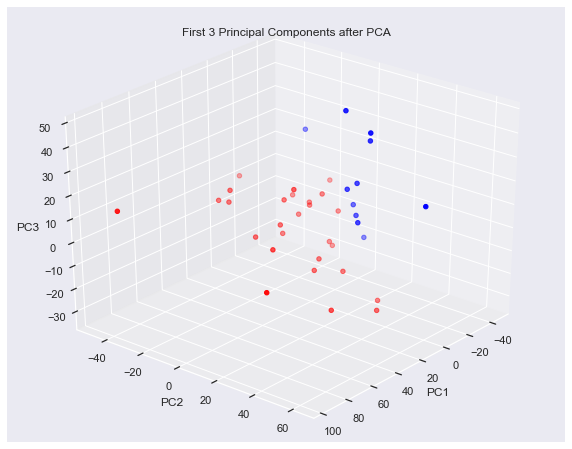

In [72]:
finalDf = pd.concat([principalDf, train_target], axis = 1)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
colors = {'ALL':'red', 'AML':'blue'}
ax.scatter(principalDf.pc1, principalDf.pc2, principalDf.pc3, 
           c=train_target.apply(lambda x: colors[x]))
plt.title('First 3 Principal Components after PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(30, 40)
plt.tight_layout
plt.show()

The above plot shows relatively clear separation of the two cancer types along the first 3 components as defined by PCA. 

Some classifiers at work without feature selection...

In [68]:
classifiers = [LogisticRegression(),
               KNeighborsClassifier(),
               SVC(),
               RandomForestClassifier(),
               MLPClassifier(),
               GaussianNB()
              ]
names = ['Logistic Regression',
         'K Nearest Neighbours', 
         'Support Vector Machine', 
         'Random Forest', 
         'Multi Layer Perceptron', 
         'Gaussian Naive Bayes'
        ]

for name, classifier in zip(names,classifiers):
    
    #fit
    clf = classifier.fit(dftrain, train_target)
    
    #predictions on test set
    pred_targets = clf.predict(dftest)
    
    #print results
    print(f'\nResults for {name}:\n')
    print(classification_report(test_target,pred_targets))
    print(confusion_matrix(test_target,pred_targets))
    
    if name == 'Random Forest':
        features = clf.feature_importances_
        feature_df = pd.DataFrame({'Feature_Importance' : features, 'Gene_Name' : dftrain.columns})
        
        print(feature_df.sort_values(by='Feature_Importance', ascending=False).head(50))


Results for Logistic Regression:

              precision    recall  f1-score   support

         ALL       1.00      0.15      0.26        20
         AML       0.45      1.00      0.62        14

    accuracy                           0.50        34
   macro avg       0.73      0.57      0.44        34
weighted avg       0.77      0.50      0.41        34

[[ 3 17]
 [ 0 14]]

Results for K Nearest Neighbours:

              precision    recall  f1-score   support

         ALL       0.62      1.00      0.77        20
         AML       1.00      0.14      0.25        14

    accuracy                           0.65        34
   macro avg       0.81      0.57      0.51        34
weighted avg       0.78      0.65      0.56        34

[[20  0]
 [12  2]]

Results for Support Vector Machine:

              precision    recall  f1-score   support

         ALL       0.59      1.00      0.74        20
         AML       0.00      0.00      0.00        14

    accuracy                       

/Users/mattijsbeirinckx/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Feature_Importance                                          Gene_Name
2775            0.024368                              PROTEASOME IOTA CHAIN
3998            0.022640  CD36 CD36 antigen (collagen type I receptor; t...
3653            0.020636  C-myb gene extracted from Human (c-myb) gene; ...
764             0.018690                              CATHEPSIN G PRECURSOR
1194            0.017738        CD33 CD33 antigen (differentiation antigen)
3896            0.017276                       ELA2 Elastatse 2; neutrophil
157             0.016968                                 ADM Adrenomedullin
1578            0.015476                                    Azurocidin gene
3984            0.015429                 PFC Properdin P factor; complement
552             0.015179                         KIAA0268 gene; partial cds
1070            0.014107                             Inducible protein mRNA
1025            0.014012                         Importin beta subunit mRNA
2716        